# Reproduction of grokking on a conv net for image classification

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [118]:
# Imports
import os
import datetime
import random
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp
import datetime

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set seeds for reproducability
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

local_host = True if 'oveggeland' in list(notebookapp.list_running_servers())[0]['notebook_dir'] else False

# Step 1: Create dataset

In [126]:
# Datasets
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)


def get_datasets(train_frac=0.3, number_occurence=100):
    """
    - train_frac: What fraction of the total amount of data should be train versus validation
    - number_occurence: Number of occurences for each number 0-9 in the total data
    """
    targets = dataset.targets.numpy()
    
    # Allocate memory for data subset
    train_idx = np.zeros((10, int(train_frac*number_occurence)))
    val_idx = np.zeros((10, number_occurence - int(train_frac*number_occurence)))
    
    # Loop over all 10 numbers in dataset
    for number in range(10):
        number_idx = np.where(targets==number)[0]
        random_selection = np.random.choice(number_idx, number_occurence)
        
        train_idx[number], val_idx[number] = train_test_split(random_selection, train_size=train_frac, random_state=seed)
        
    # Use indices to retrieve train/val split
    X_train = dataset.data[train_idx.flatten().astype(int)][:, None, :, :].double()
    Y_train = dataset.targets[train_idx.flatten().astype(int)].long()
    X_val = dataset.data[val_idx.flatten().astype(int)][:, None, :, :].double()
    Y_val = dataset.targets[val_idx.flatten().astype(int)].long()
    return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = get_datasets()
print(X_train.shape)
print(X_val.shape)

torch.Size([300, 1, 28, 28])
torch.Size([700, 1, 28, 28])


# Step 2: Define model
Using the same architecture as in lab work for IMT 4392

In [237]:
# Default network architecture
img_size = 28

# Conv layer 1
filter_size1 = 8
num_filter1  =16
pool_size1 = 2

# Conv layer 2
filter_size2 = 16
num_filter2 =36
pool_size2 = 2

# Fully connected layer
lin_input_size = int(num_filter2*(img_size/(pool_size1*pool_size2))**2)
num_neuron =  128
num_classes = 10


class NumberDetector(nn.Module):
    def __init__(self):
        super(NumberDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter1, kernel_size=filter_size1,padding=filter_size1//2)
        self.conv2 = nn.Conv2d(num_filter1, num_filter2, kernel_size=filter_size2,padding=filter_size2//2)
        self.conv3 = nn.Conv2d(num_filter2, num_filter2, kernel_size=filter_size2,padding=filter_size2//2)
        self.relu  = nn.ReLU()
        self.fc1 = nn.Linear(lin_input_size, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_classes)

    def forward(self, x):
        # Conv layer 1
        x=self.conv1(x)
        x= F.max_pool2d(x,pool_size1)
        x=self.relu(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        
        # Conv layer 2
        x = self.conv3(x)
        x = self.relu(x)
        
        # Conv layer 2
        x = self.conv3(x)
        x = self.relu(x)
        x = F.max_pool2d(x,pool_size2)
        
        # Fulle connected layer
        x = x.view(-1, lin_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training the model

In [238]:
def per_number_loss(predictions, labels, loss_fn):
    loss = np.zeros(10)
    for number in range(10):
        idx = np.where(labels==number)
        number_pred = predictions[idx]
        number_label = labels[idx]
                
        loss[number] = loss_fn(number_pred, number_label)
    return loss
        

In [239]:
def train(run_name=datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumberDetector().double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))
    loss_fn = torch.nn.CrossEntropyLoss()

    # Run formalities
    os.mkdir(save_root/run_name)
    save_dict = {'model':model.state_dict()}
    torch.save(save_dict, save_root/run_name/'init.pth')

    # Get data
    X_train, Y_train, X_val, Y_val = get_datasets(train_frac=train_frac, number_occurence=number_occurence)
    print(type(X_train)) 
    
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_number_losses = np.zeros((10, num_epochs))
    val_number_losses = np.zeros((10, num_epochs))
    
    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_pred = model(X_train)
        train_loss = loss_fn(train_pred, Y_train.to(device))
        train_losses.append(train_loss.item())

        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val.to(device))
        val_losses.append(val_loss.item())
        
        # Per number loss
        train_number_losses[:, epoch] = per_number_loss(train_pred, Y_train, loss_fn)
        val_number_losses[:, epoch] = per_number_loss(val_pred, Y_val, loss_fn)
        
        # Print status
        if epoch%100 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

        # Calc gradients and perform backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if val_loss.item() < stopping_thresh:
            break

        if (save_models) and (epoch%save_every == 0):
            if val_loss.item() < stopping_thresh:
                break
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_number_losses': train_number_losses,
        'val_number_losses': val_number_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Experiment and analyse

In [240]:
# Model params
lr=1e-3
weight_decay = 1

# Training params
num_epochs = 500
save_models = False
save_every = 10
save_root = Path("phd/IMT4392/project/numbers/checkpoints") if not local_host else Path("checkpoints")
stopping_thresh = -1

# Dataset params
train_frac = 0.1
number_occurence = 11

# Run training
exp_name = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
train(exp_name)

<class 'torch.Tensor'>


RuntimeError: shape '[-1, 1764]' is invalid for input of size 23040

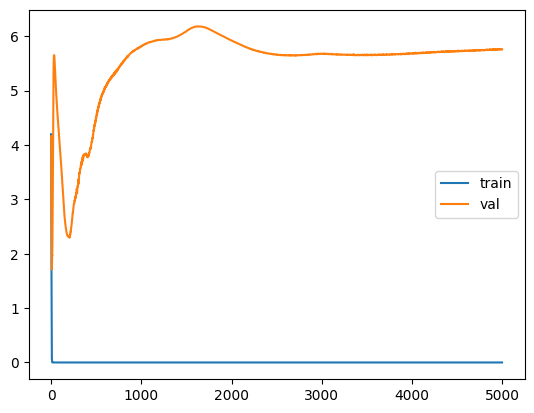

In [225]:
#Train versus val errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
    
plt.plot(load_dict['train_losses'], label='train')
plt.plot(load_dict['val_losses'], label="val")

plt.legend()
plt.show()

(10, 1000)


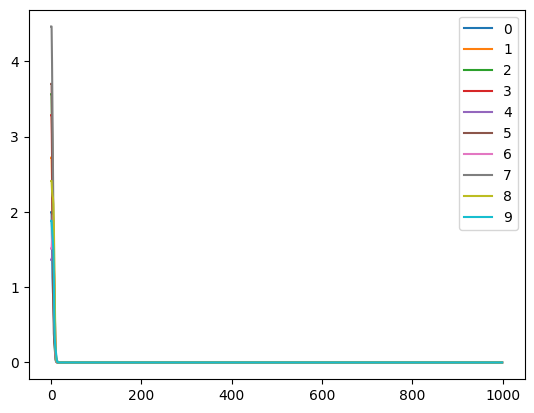

In [213]:
#Train per-number errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
print(load_dict['train_number_losses'].shape)
    
for number, losses in enumerate(load_dict['train_number_losses']):
    plt.plot(losses, label=str(number))

plt.legend()
plt.show()

(10, 1000)


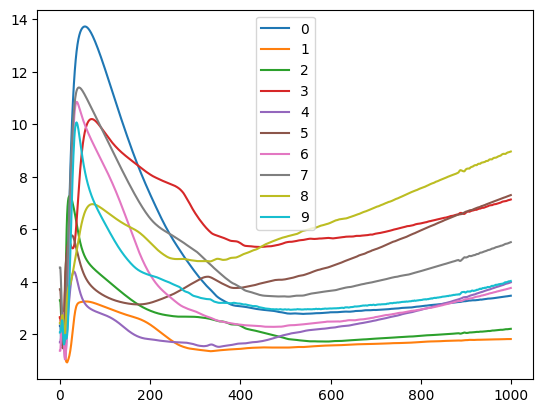

In [215]:
#Val per-number errors
load_dict = torch.load(f"checkpoints/{exp_name}/final.pth")
print(load_dict['val_number_losses'].shape)
    
for number, losses in enumerate(load_dict['val_number_losses']):
    plt.plot(losses, label=str(number))

plt.legend()
plt.show()